# Goals

*   Understand the basic concept of keyword extraction
*   Learn how embedding-based keyword extraction (KeyBERT) works
*   **Gain hands-on experience** in extracting keywords from real texts using KeyBERT
*   Additionally, practice tuning techniques such as stopword removal, multilingual support (Korean), and enhancing keyword diversity





# 1. Keyword Extraction
## Task definition
*   Identifies important **words** from document
*   Serve as metadata and support downstream tasks

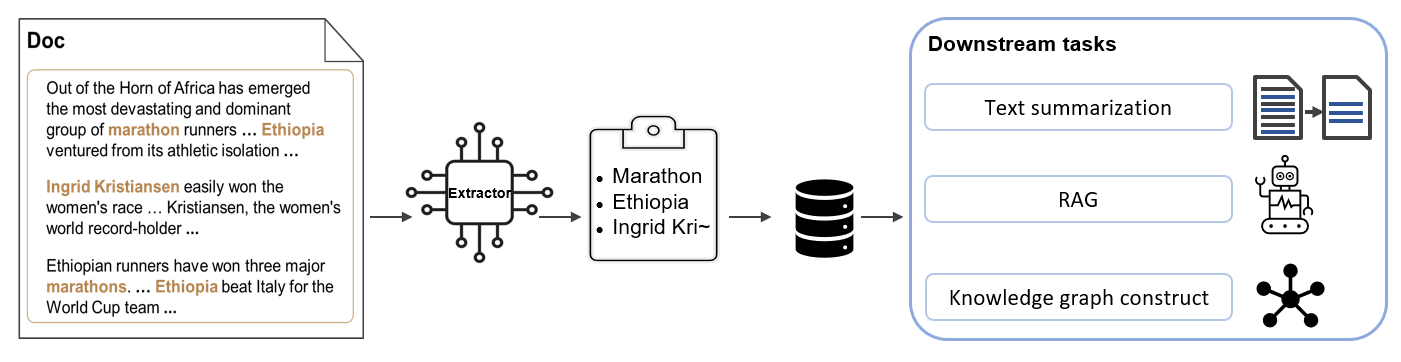





#2. KeyBERT

*   An open-source Python module for keyword extraction ([GitHub](https://github.com/MaartenGr/KeyBERT?tab=readme-ov-file))
*   A keyword extractor based on BERT embeddings
*   Extracts keywords using cosine similarity between document embeddings and word (candidate) embeddings generated by BERT


## KeyBERT Overview
1. Feed the document into a **embedding model** to obtain its embedding
vector

2. **Extract candidate keyphrases** from the document (usually noun phrases), and obtain their embeddings using the same embedding model

3. Compute the **cosine similarity** between the document embedding and each candidate embedding

4. Select the top-k candidates with the highest similarity scores as **keywords**

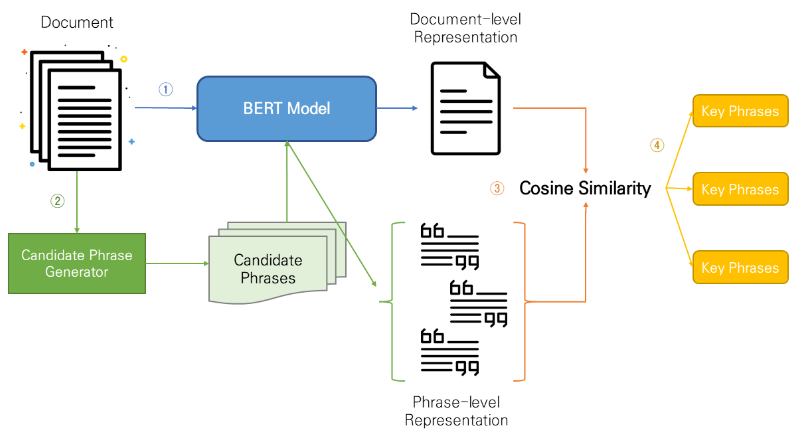

#3. Hands-on coding


###Install the required libraries


*   konlpy: A Python library for Korean natural language processing



In [ ]:
!pip install keybert
!pip install konlpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 34.2 MB/s eta 0:00:00


###KeyBERT()
*   Initialize a KeyBERT keyword extraction model
*   model: Uses a BERT-based model to generate embeddings for documents and candidate keywords ([see available models here](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html))



In [ ]:
from keybert import KeyBERT
kw_model = KeyBERT(model='all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

###😺 extract_keywords 🐈


*   keyphrase_ngram_range: Specify the range of keyword lengths
*   top_n: Extract the top n keywords



In [ ]:
doc = """
Cats are graceful and mysterious animals, capturing hearts with their bright eyes and soft fur.
However, their sharp claws and unpredictable behavior can sometimes be frightening.
They quietly follow their owner's steps, making it feel like we are invited into their secret lives.
Cats show great interest in even a tiny treat, treating their owners as if they were their servants.
Sometimes, playful attacks surprise their owners, but this is part of their charm.
Nevertheless, their cuteness and lovable nature make us forgive everything.
"""
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 4),top_n=5)
print(keywords)

[('cats great tiny treat', 0.6265), ('playful attacks surprise owners', 0.5961), ('owners servants playful attacks', 0.5658), ('cats graceful mysterious animals', 0.56), ('claws unpredictable behavior frightening', 0.541)]


###Maximal Margin Relevance (MMR)
**Increase keyword diversity**
* Without MMR: Select keywords only with high similarity to the document
* With MMR: Select keywords with high document similarity and low similarity to each other






In [ ]:
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 4), use_mmr=True, diversity=0.5,top_n=5)  #  diversity: Controls keyword diversity (range: 0–1, where 1 gives the highest diversity)
print(keywords)

[('cats great tiny treat', 0.6265), ('playful attacks surprise owners', 0.5961), ('soft fur sharp claws', 0.4667), ('animals capturing hearts', 0.4093), ('lovable nature make forgive', 0.2913)]


In [ ]:
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 4), stop_words='english', use_mmr=True, diversity=0.5,top_n=5)  #  stop_words: Remove common English stopwords (e.g., 'the', 'is', 'and')
print(keywords)

[('cats great tiny treat', 0.6265), ('playful attacks surprise owners', 0.5961), ('soft fur sharp claws', 0.4667), ('animals capturing hearts', 0.4093), ('lovable nature make forgive', 0.2913)]


###Keyword Extraction from Long Documents
* Most models have a token limit (~512 tokens), so long documents can't be processed at once
* Split the text into smaller segments (by sentences or fixed length) before extracting keywords


In [ ]:
from sentence_transformers import SentenceTransformer

doc = """
Cats are graceful and mysterious creatures. Their bright eyes are full of curiosity,
and their soft purrs make us feel calm. These independent yet loving animals make
any home warm and happy. They love playful activities and daily adventures, always
full of surprises. Despite their aloof nature, cats know how to win our hearts with
their charm and affection.
""" * 10  # Simulate a long document

tokenizer = SentenceTransformer('all-mpnet-base-v2').tokenizer
tokens_doc = tokenizer(doc, truncation=False, return_tensors='pt')
print("Total document token length:", len(tokens_doc['input_ids'][0]))


Token indices sequence length is longer than the specified maximum sequence length for this model (702 > 384). Running this sequence through the model will result in indexing errors


Total document token length: 702


In [ ]:
# Download the sentence tokenizer (run once)
import nltk # Provide tools for natural language processing
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import CountVectorizer
import json
from sentence_transformers import SentenceTransformer

kw_model = KeyBERT(model='all-mpnet-base-v2')

sentence_model = SentenceTransformer('all-mpnet-base-v2')
kw_model = KeyBERT(model=sentence_model)


doc = """
Cats are graceful and mysterious creatures. Their bright eyes are full of curiosity,
and their soft purrs make us feel calm. These independent yet loving animals make
any home warm and happy. They love playful activities and daily adventures, always
full of surprises. Despite their aloof nature, cats know how to win our hearts with
their charm and affection.
""" * 10  # Simulate a long document

# Split the document into segments (e.g., by sentence or fixed length)
sentences = nltk.sent_tokenize(doc)
segment_size = 5  # Number of sentences per segment
segments = [' '.join(sentences[i:i+segment_size]) for i in range(0, len(sentences), segment_size)]

# Extract keywords for each segment
segment_keywords = []

for i, seg in enumerate(segments):
    keywords = kw_model.extract_keywords(
        seg,
        keyphrase_ngram_range=(1, 4),
        stop_words='english',
        use_mmr=True,
        diversity=0.7,
        top_n=5
    )
    segment_keywords.append({
        "segment_id": i,
        "segment_text": seg,
        "keywords": keywords
    })



# Save the results as a JSON file
with open("segment_keywords.json", "w", encoding="utf-8") as f:
    json.dump(segment_keywords, f, indent=4, ensure_ascii=False)

print(json.dumps(segment_keywords[:2], indent=2, ensure_ascii=False))



[
  {
    "segment_id": 0,
    "segment_text": "\nCats are graceful and mysterious creatures. Their bright eyes are full of curiosity,\nand their soft purrs make us feel calm. These independent yet loving animals make\nany home warm and happy. They love playful activities and daily adventures, always\nfull of surprises. Despite their aloof nature, cats know how to win our hearts with\ntheir charm and affection.",
    "keywords": [
      [
        "cats graceful mysterious creatures",
        0.6766
      ],
      [
        "make feel calm independent",
        0.2162
      ],
      [
        "make home warm",
        0.1607
      ],
      [
        "activities daily adventures surprises",
        0.1531
      ],
      [
        "win",
        0.051
      ]
    ]
  },
  {
    "segment_id": 1,
    "segment_text": "Cats are graceful and mysterious creatures. Their bright eyes are full of curiosity,\nand their soft purrs make us feel calm. These independent yet loving animals make\nany hom

#🕵️Keyword extraction on Korean documents



*  Need to use a model that supports Korean embeddings (e.g., bert-base-multilingual-cased)

* KeyBERT does not provide built-in stopword removal for Korean, so a Korean stopword file is needed



In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') # You can also use 'snunlp/KR-SBERT-V40K-klueNLI-augSTS'
# sentence_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
kw_model = KeyBERT(model=model)

with open("korean_stopwords.txt", "r", encoding="utf-8") as f:
    korean_stopwords = [line.strip() for line in f if line.strip()]


doc = """
        서울의 한 낡은 아파트, 10층.
정오를 갓 지난 시간, 문틈 사이로 희미한 비명 소리가 새어 나왔다.

형사 현구는 10층 복도에 서서 숨을 고르며 문을 두드렸다.
“여기 누구 있나요?”
대답은 없었다. 다만, 바닥에 떨어진 작은 금속 열쇠 하나가 반짝였다.

현구는 조심스럽게 문을 열고 방 안으로 들어섰다.
책상 위에는 한 통의 편지가 놓여 있었다. 붉은 잉크로 쓰인 글귀:

"진실은 바로 내 손에 있어. 하지만 열쇠는 이미 떠났다."

방 안을 살펴보던 현구의 눈에 들어온 것은 벽에 걸린 오래된 사진이었다.
사진 속에는 세 명의 남자가 웃고 있었다. 가운데 남자는 최근에 실종된 재벌 2세 서ㅇㅇ였다.

그 순간, 현구는 바닥에 떨어진 열쇠를 집어 들었다.
열쇠 구멍은 책상 서랍과 완벽하게 맞았다. 서랍을 열자, 안에는 작은 USB가 들어 있었다.
USB를 컴퓨터에 꽂자, 화면에 한 문장이 떴다.

"모든 단서는 나를 찾는 너희를 위한 게임이다."

민재는 곧 깨달았다. 이번 사건은 단순한 실종 사건이 아니라, 치밀하게 설계된 퍼즐이라는 것을.
그리고 그 퍼즐은… 아직 끝나지 않았다.

복도에 돌아서자, 현구의 휴대폰에 익명의 메시지가 도착했다.

“지금 바로 11층으로 오세요. 진실이 기다립니다.”

현구는 심장을 조이며 엘리베이터 버튼을 눌렀다.
그 순간, 뒤에서 발자국 소리가 들렸다.

“누구지…”
현구가 돌아보는 순간, 그림자 하나가 복도를 가로질렀다.
그리고 속삭였다.

“게임은 이제 시작이야.”
      """

keywords = kw_model.extract_keywords(
    doc,
    keyphrase_ngram_range=(1, 4),
    use_mmr=True,
    diversity=0.3,
    top_n=10
)
print("🔹 Without stopwords:")
for kw, score in keywords:
    print(f"  {kw} ({score:.4f})")

# With stopwords
keywords = kw_model.extract_keywords(
    doc,
    keyphrase_ngram_range=(1, 4),
    stop_words=korean_stopwords,
    use_mmr=True,
    diversity=0.3,
    top_n=10
)
print("\n🔹 With stopwords:")
for kw, score in keywords:
    print(f"  {kw} ({score:.4f})")


🔹 Without stopwords:
  문을 두드렸다 여기 누구 (0.6764)
  고르며 문을 두드렸다 (0.6114)
  형사 현구는 10층 (0.5950)
  현구는 조심스럽게 문을 (0.5745)
  현구는 바닥에 떨어진 열쇠를 (0.5736)
  열쇠 구멍은 책상 서랍과 (0.5418)
  현구는 심장을 조이며 엘리베이터 (0.5048)
  서울의 낡은 아파트 10층 (0.5010)
  작은 usb가 들어 있었다 (0.4778)
  익명의 메시지가 도착했다 (0.4515)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', '하기만', '하는', '하는것만', '하는것이', '하다', '하면', '하지', '한하다', '할수록', '함으로써', '해도', '해서는', '형식으로', '힘이'] not in stop_words.
  warnings.warn(



🔹 With stopwords:
  고르며 문을 두드렸다 있나요 (0.6995)
  문을 두드렸다 있나요 (0.6582)
  문을 두드렸다 있나요 대답은 (0.6496)
  형사 현구는 10층 (0.5950)
  들었다 열쇠 구멍은 책상 (0.5785)
  현구는 조심스럽게 문을 (0.5745)
  메시지가 도착했다 지금 11층으로 (0.5621)
  현구는 심장을 조이며 엘리베이터 (0.5048)
  작은 usb가 들어 있었다 (0.4778)
  서울의 낡은 아파트 (0.4401)


* okt.phrases(): Extracts noun phrases from a Korean document

* candidates parameter: Specifies a predefined list of candidate keyphrases for KeyBERT

In [ ]:
from konlpy.tag import Okt

okt = Okt()

candidates = okt.phrases(doc)

keywords = kw_model.extract_keywords(
    doc,
    candidates=candidates,
    keyphrase_ngram_range=(1, 4),
    stop_words=korean_stopwords,
    use_mmr=True,
    diversity=0.3,
    top_n=10,
)

print(keywords)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에',

[('문틈', 0.4668), ('실종된 재벌', 0.4626), ('형사', 0.4599), ('실종된 재벌 2세', 0.4278), ('작은 금속 열쇠', 0.4184), ('엘리베이터', 0.4167), ('실종', 0.4068), ('10층', 0.3747), ('희미한 비명', 0.3626), ('책상', 0.2561)]


#Additional: Named Entity Recognition (NER)
* Identify named entities such as people, locations, organizations, and dates within text and classify them by type

* Example: “Steve Jobs founded Apple in California.” → Steve Jobs (PERSON), Apple (ORGANIZATION), California (LOCATION)
###GLiNER
* Provides an open-source, general-purpose NER model applicable across diverse domains and languages [(GitHub)](https://github.com/urchade/GLiNER)

In [ ]:
pip install gliner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


In [ ]:
from gliner import GLiNER

# Initialize GLiNER with the base model
model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")

doc = """
        서울의 한 낡은 아파트, 10층.
정오를 갓 지난 시간, 문틈 사이로 희미한 비명 소리가 새어 나왔다.

형사 현구는 10층 복도에 서서 숨을 고르며 문을 두드렸다.
“여기 누구 있나요?”
대답은 없었다. 다만, 바닥에 떨어진 작은 금속 열쇠 하나가 반짝였다.

현구는 조심스럽게 문을 열고 방 안으로 들어섰다.
책상 위에는 한 통의 편지가 놓여 있었다. 붉은 잉크로 쓰인 글귀:

"진실은 바로 내 손에 있어. 하지만 열쇠는 이미 떠났다."

방 안을 살펴보던 현구의 눈에 들어온 것은 벽에 걸린 오래된 사진이었다.
사진 속에는 세 명의 남자가 웃고 있었다. 가운데 남자는 최근에 실종된 재벌 2세 서ㅇㅇ였다.

그 순간, 현구는 바닥에 떨어진 열쇠를 집어 들었다.
열쇠 구멍은 책상 서랍과 완벽하게 맞았다. 서랍을 열자, 안에는 작은 USB가 들어 있었다.
USB를 컴퓨터에 꽂자, 화면에 한 문장이 떴다.

"모든 단서는 나를 찾는 너희를 위한 게임이다."

민재는 곧 깨달았다. 이번 사건은 단순한 실종 사건이 아니라, 치밀하게 설계된 퍼즐이라는 것을.
그리고 그 퍼즐은… 아직 끝나지 않았다.

복도에 돌아서자, 현구의 휴대폰에 익명의 메시지가 도착했다.

“지금 바로 11층으로 오세요. 진실이 기다립니다.”

현구는 심장을 조이며 엘리베이터 버튼을 눌렀다.
그 순간, 뒤에서 발자국 소리가 들렸다.

“누구지…”
현구가 돌아보는 순간, 그림자 하나가 복도를 가로질렀다.
그리고 속삭였다.

“게임은 이제 시작이야.”
      """

# Labels for entity prediction
# Most GLiNER models should work best when entity types are in lower case or title case
labels = [
    "Person",
    "Location",
    "Object",
]

# Perform entity prediction
entities = model.predict_entities(doc, labels, threshold=0.5)

# Display predicted entities and their labels
for entity in entities:
    print(entity["text"], "=>", entity["label"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

gliner_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/781M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/781M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


서울의 => Location
10층 => Location
현구는 => Person
10층 => Location
복도에 => Location
열쇠 => Object
현구는 => Person
책상 => Object
편지가 => Object
열쇠는 => Object
방 안을 => Location
현구의 => Person
현구는 => Person
바닥에 => Location
열쇠를 => Object
열쇠 => Object
USB가 => Object
USB를 => Object
민재는 => Person
퍼즐은 => Object
복도에 => Location
현구의 => Person
현구는 => Person
현구가 => Person


## Hands-on Practice: Your Own Keyword Extraction
In this exercise, try extracting keywords **from a document of your choice**.  
You can upload your own text or use one generated by GPT or another AI model.
- Ex: "Please write a short detective story that doesn’t exceed the BERT model’s token limit"

#📚Keyword Extraction Assignment😱😭

##Objective:
Use KeyBERT to extract keywords from a document of your choice and analyze how segmentation affects the extracted results.

##Instructions:

1. Choose any document you find interesting (e.g., a short article, essay, or report) that does not exceed the token limit of the model.

2. Use **KeyBERT** to extract keywords in two different ways:  
   - **(a)** Extract the **top 10** keywords from the **entire document** at once.  
   - **(b)** Split the document into **two equal parts** and extract the **top 5** keywords from **each part** separately.  
3. Present the results:
    - List the extracted keywords for (a) and for (b) clearly (e.g., in a table or bullet list).
    - Include the similarity scores provided by KeyBERT for each keyword.
4. Compare and analyze:  
    - **(Required)** Identify how the extracted keywords differ between (a) and (b).  
&nbsp;&nbsp;&nbsp;&nbsp;- Are there any keywords that appeared only in the segmented version but not in the full-document extraction?  
    - **(Required)** Check the similarity between the **same keywords** that appear in both cases — i.e., when a keyword is extracted from the full document and also from one of its segments.  
&nbsp;&nbsp;&nbsp;&nbsp;- Compare their similarity scores with the **whole document** and with the **corresponding segment**.  
    - **(Optional – Your own analysis)** Summarize your observations and provide your interpretation of **why segmentation might influence keyword extraction results**.

